# Neurons Dataset of 1k Cells from E18 Mice

For this experiment, we will be doing low throughput analysis on a mice dataset, specifically tissue from their brains. The dataset consists of 1000 neuron cells from an E18 mouse. 

*E18 mice are chosen to prevent earlier glial contamination in any cortical structures (that is, relating to the cerebrum). Postnatal pups can be challenging as initial morphological changes and growth changes are acivity-dependent during this period. It is around E12 when the critical period for gross defects of any neuronal component passes. By E18, most neuronal structures have developed fully (septum, amgydala, midbrain, cerebral cortex, thalamus, corpus striatum). There are also partially differentiated stem cells in addition to organogenesis.*

### Import Libraries

To begin, let's run the following two cells to install the libraries and packages that we will need for our analysis.

In [ ]:
!pip install scanpy
!pip install harmonypy
!pip install scikit-misc
!pip3 install leidenalg

In [93]:
while True:
    try:
        import sys
        import os
        import numpy as np
        import pandas as pd
        import scanpy as sc
        import seaborn as sb
        import matplotlib.pyplot as plt
        break
    except:
        print("***Some packages have not been installed. Installing now...***")
        import subprocess
        import urllib.request

        # Retrieve installer if not available
        remove = False
        if not os.path.exists("get-pip.py"):
            urllib.request.urlretrieve("https://bootstrap.pypa.io/get-pip.py", "get-pip.py")
            remove = True
        subprocess.check_call([sys.executable, "get-pip.py"])
        # Download and install packages if not installed
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])

        # Packages used but not included in scanpy package
        subprocess.check_call([sys.executable, "-m", "pip", "install", "harmonypy"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-misc"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "leidenalg"])

        # Remove installer if it wasn't available before for discretion
        if remove: os.remove("get-pip.py")
print("Package import success!")

Package import success!


### Parse Commands and Import data

These will be default numbers if the user does not change these inputs. Much of these are variable throughout experiments so the defaults will be basic at best.

In [94]:
# file_location = "data/"
batch_effect = None
n=-1                    #Initialized later
cluster_res = 1.0
min_cells = 0
min_genes = 0
genes = []

cellranger_script =""
string_id=""
reference_transcriptome=""
fastqs=""
sample=""
expected_cells=0
local_cores=0
local_mem=0

In [95]:
#Cellranger Arguments
cellranger_script_arg = "--script"
string_id_arg = "--id"
reference_transcriptome_arg = "--transcriptome"
fastqs_arg = "--fastqs"
sample_arg = "--sample"
expected_cells_arg = "--min_genes"
local_cores_arg = "--cores"
local_mem_arg = "--mem"

These arguments will be dependent on user input. User will check visualizations and other experiment variables to decide input to optimize the experiment to their needs.



In [96]:
#Scanpy Arguments
file_arg = "--loc"
batch_arg = "--batch"
n_arg = "--neighbors"
resoution_arg = "--res"
cell_arg = "--min_cells"
gene_arg = "--min_genes"
display_arg = "--genes"

Parse arguments for some user inputs. Our python script will check these arguments but they are currently not necessary in our jupyter notebook.


In [97]:
args = sys.argv[1:]
for arg in args:
    #if file_arg+"=" in arg:
    #    file_location = arg[arg.index("=") + 1:]
    if batch_arg+"=" in arg:
        batch_effect = arg[arg.index("=") + 1:]
    elif n_arg+"=" in arg:
        n = int(arg[arg.index("=") + 1:])
    elif resoution_arg+"=" in arg:
        cluster_res = float(arg[arg.index("=") + 1:])
    elif cell_arg+"=" in arg:
        min_cells = float(arg[arg.index("=") + 1:])
    elif gene_arg+"=" in arg:
        min_genes = float(arg[arg.index("=") + 1:])

    elif cellranger_script_arg+"=" in arg:
        cellranger_script = arg[arg.index("=") + 1:]
    elif string_id_arg+"=" in arg:
        string_id = arg[arg.index("=") + 1:]
    elif reference_transcriptome_arg+"=" in arg:
        reference_transcriptome = arg[arg.index("=") + 1:]
    elif fastqs_arg+"=" in arg:
        fastqs = arg[arg.index("=") + 1:]
    elif sample_arg+"=" in arg:
        sample = arg[arg.index("=") + 1:]
    elif expected_cells_arg+"=" in arg:
        expected_cells = float(arg[arg.index("=") + 1:])
    elif local_cores_arg+"=" in arg:
        local_cores = float(arg[arg.index("=") + 1:])
    elif local_mem_arg+"=" in arg:
        local_mem = int(arg[arg.index("=") + 1:])

    elif display_arg+"=" in arg:                 #Genes listed must be comma separated
        genes = arg[arg.index("=") + 1:].split(",")

    else: pass
        #sys.exit(arg+" is not a valid argument!")

 ***
Lets read in the data from the cellranger output. Cellranger outputs a features.tsv file, a barcode file, and the matrix file. Features are the genes, barcode are the cells, and the matrix is the actual data. Anndata is a Scanpy object that can hold all these important variables and data.

In [98]:
adata = sc.read_10x_mtx("data/")
if n == -1:
  n = round(np.sqrt(adata.n_obs))

### View Data

As mentioned, there are approximately 1000 cells from the E18 mice, and thus about 1000 cells in our dataset. From this dataset, there are about 31k genes.


In [99]:
print("adata.obs length: "+str(adata.n_obs))
adata.obs.head()

adata.obs length: 1208


""
AAACGGGTCGGAATCT-1
AAAGATGCACTGCCAG-1
AAAGATGGTCAGCTAT-1
AAAGTAGTCCTGCCAT-1
AAATGCCAGACTCGGA-1


In [100]:
print("adata.var length: "+str(adata.n_vars))
adata.var.head()

adata.var length: 32285


,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm19938,ENSMUSG00000102331,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression


***


<br>
Lets quickly check the highest expressed genes. As seen, MT genes seem to be highly expressed, and thus will be a cause of concern for our experiment. In standard sCRNA-seq experiments, the common thought is to remove MT genes as a sign of low quality cells due to cell perforation of cytoplasmic RNA loss. However for NASA's Genelab, spaceflight seems to affect mitochondrial gene function, according to our Genelab researcher Dr. Afshin Beheshti.* Therefore we have made the decision to not remove mitochondrial reads because that would filter our goal of analyzing biological processes from spaceflight. 

**Inclusion of mitochondrial reads is vital as spaceflight has demonstrated its involvement in the following:*
- innate immunity 
- lipid metabolism
  => can contribute to greater risk of cardiovascular issues
- gene regulation 
- ETC, ATP synthesis (from increased radiation)
  - increased levels of oxidative damage and stress
  - muscle loss from metabolic flux changes

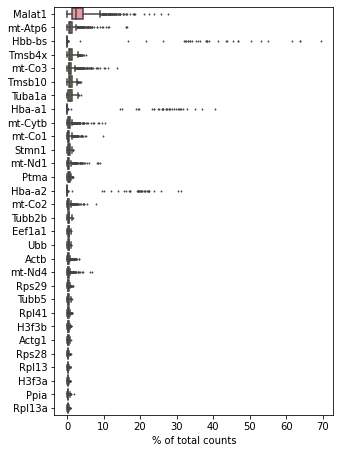

In [101]:
sc.pl.highest_expr_genes(adata)

**Hbb** refers to the hemoglobin (-bs for beta subunit s chain and -a1 for alpha subunit 1 chain). It is typically responsible for the delivery of oxygen in red blood cells to peripheral tissues. Recognizing Hbb's role in oxygen transport and its high expression in the neuronal cells here makes sense to us. The brain is stated to use around 20% of the total required oxygen in the body.

We also see expression of mt-Co3, -Co2, -Co1 , mt-Atp6. Having not filtered any mitochondrial reads, this is expected. The mt-CO3 gene encodes for the enzyme COX3 (one of the three subunits). COX helps to catalyze the transfer of electrons to that of oxygen as well as encoding for other prostaglandins (mediating any inflammation).

## Quality Control

### Basic Filtering

Our first important step in our analysis will be to do some quality control. Our 3 most important steps of quality control are:
- Basic filtering 
- Removal of highly expressed genes
- Batch Effect correction

In a standard scRNAseq experiment, there will be 4 steps, including removing MT reads. But of course, of spaceflight experiments, we at Genelab have decided to not include this step in our analysis.

***

Our analysis library of choice, scanpy, has a convient function that allows us calculate a number of quality metrics about the data. 

sc.pp.calculate_qc_metrics will give us 2 dataframes, a cell quality dataframe and a gene quality dataframe.

In [102]:
# Quality control - calculate QC cmetrics
stats = sc.pp.calculate_qc_metrics(adata)
cell_qc_dataframe = stats[0]
gene_qc_dataframe = stats[1]

Lets take a quick look at the cell and gene qc dataframes.

In [103]:
cell_qc_dataframe.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACGGGTCGGAATCT-1,3569,8.180321,13169.0,9.485697,24.626016,35.158326,47.270104,62.457286
AAAGATGCACTGCCAG-1,3708,8.218518,12979.0,9.471165,24.593574,37.861160,49.372063,62.755220
AAAGATGGTCAGCTAT-1,3509,8.163371,11104.0,9.315151,17.876441,28.170029,40.435879,57.582853
AAAGTAGTCCTGCCAT-1,196,5.283204,558.0,6.326149,73.835125,82.795699,100.000000,100.000000
AAATGCCAGACTCGGA-1,1315,7.182352,3271.0,8.093157,31.427698,43.870376,56.496484,75.084072


In [104]:
gene_qc_dataframe.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,19,0.015728,0.015606,98.427152,19.0,2.995732
Gm1992,0,0.000000,0.000000,100.000000,0.0,0.000000
Gm19938,190,0.198675,0.181217,84.271523,240.0,5.484797
Gm37381,0,0.000000,0.000000,100.000000,0.0,0.000000
Rp1,2,0.001656,0.001654,99.834437,2.0,1.098612


These metrics will be used to graph our quality control graphs to find thresholds.

***

Helper class that displays a vertical line that follows cursor when viewing plot. 

This is implementation is a madified version of Matplotlib's open source code: https://matplotlib.org/stable/gallery/misc/cursor_demo.html

In [105]:
class VerticalCursor:
    """
    A cross hair cursor.
    """
    def __init__(self, ax, x_name):
        self.ax = ax
        self.vertical_line = ax.axvline(color='red', lw=0.8)
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)
        self.x_name = x_name

    def set_cross_hair_visible(self, visible):
        need_redraw = self.vertical_line.get_visible() != visible
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line position
            self.vertical_line.set_xdata(x)
            self.text.set_text(self.x_name+'=%1.2f' % x)
            self.ax.figure.canvas.draw()

Looking at this graph, user must decide where to do the minimum cutoff for minimum genes. It is necessary to filter cells based on minimum genes because with that threshold, we can filter cells that have may have been contaminated. Lets take a closer look at the abnormal peak and at around 200 genes. 

Zoom into graph by clicking onto the magnifying glass and drawing a rectangle  near the origin (bottom left corner). A disturbed graph will have a peak on the an abnormal peak and dip before heading into the standard distribution peak. We can see an abnormal peak from 0-200 indicating some sort of contamination at around 200 minimum cells. Thus 200 min cells will be our threshold for filtering cells.

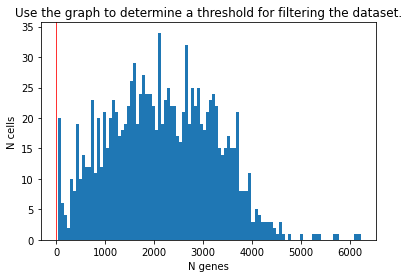

In [106]:
fig, ax = plt.subplots()
cursor = VerticalCursor(ax, "min_genes")
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)

plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.title("Use the graph to determine a threshold for filtering the dataset.")
plt.show()

Collect user input for filtering genes. Can be left blank if arguments already given or for default parameters.

In [107]:
while True:
  try:
    g_value = input("Input min_genes threshold. Leave blank to use argument/default value: ")
    if g_value == "": break
    min_genes = int(g_value)
    break
  except:
    print("\nError: Please enter an integer value or leave blank!")

Input min_genes threshold. Leave blank to use argument/default value: 


Our next order of business is to filter out genes that who have low expression levels across cells. It is important to do gene filtering after cell filtering because some genes may be detected only in low quality cells. 

Lets start by graphing cells vs the number of genes they express. 

After zooming in again, It seems as if most cells express a good number of genes, which we would expect as a cell. Lets take a closer look at at around zero.

We see a weird peak at around about 1 cell which may be a good min_cells for removing our genes. 

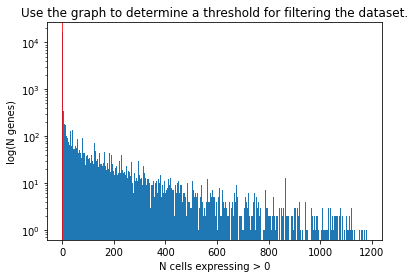

In [108]:
fig, ax = plt.subplots()
cursor = VerticalCursor(ax, "min_cells")
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)

plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') 
plt.yscale('log')
plt.title("Use the graph to determine a threshold for filtering the dataset.")
plt.show()

Collect user input for filtering cells. Can be left blank if arguments already given or for default parameters.

In [109]:
while True:
  try:
    c_value = input("Input min_cells threshold. Leave blank to use argument/default value: ")
    if c_value == "": break
    min_cells = int(c_value)
    break
  except:
    print("\nError: Please enter an integer value or leave blank!")

Input min_cells threshold. Leave blank to use argument/default value: s

Error: Please enter an integer value or leave blank!
Input min_cells threshold. Leave blank to use argument/default value: 


For our defaults, because basic filtering be extremely variable throughout experiments, we have decided to keep defaults at zero until user input after seeing graphs. 

In [110]:
unfiltered_genes = adata.var_names
cell_filter_percentile = 0.01
gene_filter_percentile = 0.01

#### Filter

In [111]:
if min_cells != 0 or min_genes != 0:             #User input filtering
  print("Filtering using min_genes="+str(int(min_genes))+" and min_cells="+str(int(min_cells))+".")
  sc.pp.filter_cells(adata, min_genes = min_genes)
  sc.pp.filter_genes(adata, min_cells = min_cells)
else:                                            #Percentile-based filtering (default)
  print("Filtering using default settings.")
  stats = sc.pp.calculate_qc_metrics(adata)
  gene_counts_mean = np.mean(stats[0]['n_genes_by_counts'])
  cell_counts_mean = np.mean(stats[1]['n_cells_by_counts'])

  sc.pp.filter_cells(adata, min_genes = round(gene_counts_mean*cell_filter_percentile))
  sc.pp.filter_genes(adata, min_cells = round(cell_counts_mean*gene_filter_percentile))

Filtering using default settings.


In [112]:
filtered_genes = np.setdiff1d(unfiltered_genes, adata.var_names)
print(str(len(filtered_genes))+" genes filtered")

14752 genes filtered


#### To compare filter results

Batch effect correction is a quality control method of lowering technical noise. It can help us visualize more complete clusters.

In [113]:
# Review obs after draft is complete
if not batch_effect == None:
  sc.pp.pca(adata)
  sc.external.pp.harmony_integrate(adata, key=batch_effect)

### Normalize and Logarithmize Data

As its name suggests, sc.pp.normalize_total will normalize the total number of counts per cell so that every cell will have the same number of total counts. Normalization will help to preserve biological heterogeneity without the influence of any technical noise like sequencing depth and gene abundance.

target_sum = 1e6 here refers to counts per million. 

Although different methods of normalization does exist, that are more accurate and have better performance, the CPM method is more flexible and scalable to all datasets and pipelines making it the best choice for our Genelab pipeline.

sc.pp.log1p helps to logarithmize the data to improve data "symmetry" on a linear scale for more relevant and accurate data. For further information on this topic, feel free to check out the following link: https://blog.qbaseplus.com/seven-tips-for-bio-statistical-analysis-of-gene-expression-data

In [114]:
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)

### Remove highly variable genes

Determine and remove highly variable genes based on each genes' mean and variance. Removing these genes eliminates noise due to high variability in the data.

Algorithm: Each gene is put into 20 'bins' based and their mean and variance. Each gene is then normalized based on the other genes in their bin. If a gene's normalized dispersion is greater or equal to a z-score of 2 (~98th percentile) AND the gene has a low mean cell count, it is marked highly variable.

Note: warning just means it will proceed to automatically calculate PCA since it was not done beforehand.

In [115]:
sc.pp.highly_variable_genes(adata, flavor='seurat', min_disp=2)
highly_variable = adata[:, adata.var.highly_variable==True].var_names
print(str(len(adata.var[adata.var['highly_variable']==True]))+"/"+str(adata.n_vars)+" genes are highly variable")
adata = adata[:, adata.var.highly_variable==False]

394/17533 genes are highly variable


### K-Nearest Neighbors

Calculate the distance between each cell using the KNN algorithm. Distances will be used to cluster the cells in the next step.

Default (n=sqrt(adata.n_obs)): setting n as the square root of the length of the data is the general consensus if n is not provided.

Sources:

https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb

https://discuss.analyticsvidhya.com/t/how-to-choose-the-value-of-k-in-knn-algorithm/2606/7

https://stackoverflow.com/questions/11568897/value-of-k-in-k-nearest-neighbor-algorithm

In [116]:
print("\n*Ignore the following warning.")
sc.pp.neighbors(adata, n_neighbors=n)


*Ignore the following warning.
         Falling back to preprocessing with `sc.pp.pca` and default params.


### Cluster

Cluster/Group each cell based on the distances calculated in the previous step using the Leiden algorithm.

'resolution' determines the amount of clusters that will be formed (default: 1.0. The higher the resolution, the more clusters in the result)

In [117]:
sc.tl.leiden(adata, resolution=cluster_res)

## Visualize Results

Prepares the data to be visualized by simplifying multiple dimensions down to two dimensional coordinates using the UMAP algorithm. 

This algoithm also uses the distances calculated using 'neighbors()' 

In [118]:
sc.tl.umap(adata)

### Clusters

Plot the UMAP data and color based on the clusters determined previously. We will later use label these clusters with cell types using marker gene identification.


... storing 'feature_types' as categorical


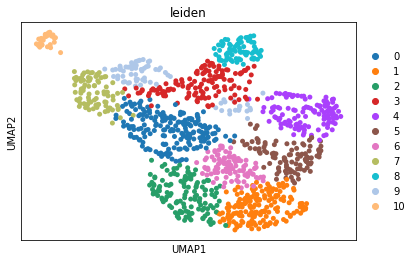

In [119]:
sc.pl.umap(adata, color=['leiden'])

### Color based on selected gene(s)

Color cells based on their expression of a specific gene. If list of genes was not provided, the first 16 genes will be displayed.

Note: purple = no expression

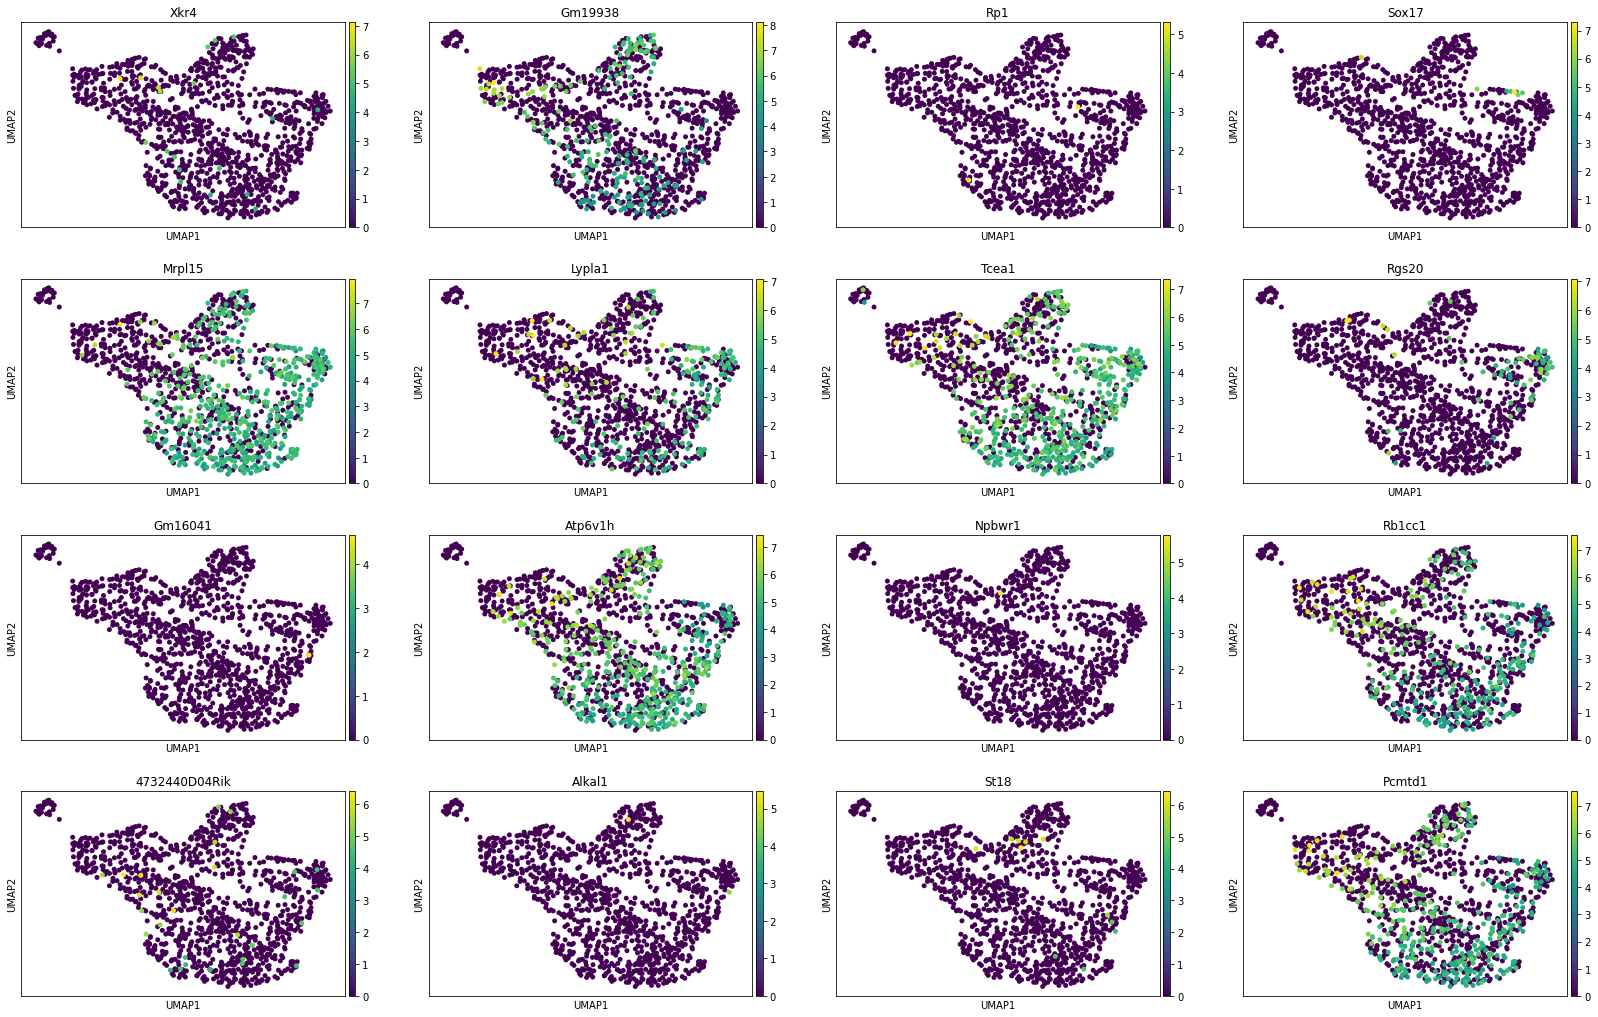

In [120]:
view_genes = []
if len(genes) != 0:    #Display selected genes' expression
    for gene in genes:
        if gene in adata.var_names:
            view_genes.append(gene)
        elif gene in highly_variable:
            print(gene+" gene was highly variable and was filtered out.")
        elif gene in filtered_genes:
            print(gene+" gene had been filtered out.")
        else:
            print(gene+" gene does not exist in the dataset.")
else:                  #Display expression of the first 16 genes in adata
    #View the first 16 genes
    view_genes = []
    i = 16
    for gene in adata.var_names:
        view_genes.append(gene)
        i -= 1
        if i==0: break

sc.pl.umap(adata, color=view_genes)